# Starting with Martin's Gates

- This was a first, rough run-through for the VQE simulation workflow. 
- I am using Natalie & Martin's work ([1803.03326v3](https://arxiv.org/abs/1803.03326)) as a reference, replicating what they've done.
- In this notebook, I use Qiskit's codebase only minimally: consequently, the code is verbose but explicit, and it may be useful when trying to understand what happens in a VQE simulation.

### Background information for reference
The Schwinger model is a $1+1$D theory of quantum electrodynamics (QED). It describes fermions as a two-component spinor field $\psi$, with mass $m$, coupled via charge $g$ to an electromagnetic field $A_\mu$ in infinite continuum space, with the Lagrangian given by

\begin{equation}
    \mathcal{L} = \bar{\psi} \left(i \gamma^\mu D_\mu - m \right) \psi - \frac{1}{4} F_{\mu\nu} F^{\mu\nu},
\end{equation}

where the covariant derivative $D$ and the field strength tensor $F_{\mu\nu}$ are respectively given by

\begin{equation}
\label{eq:schwinger-auxiliary}
\begin{aligned}
    \gamma^\mu D_\mu &= \gamma^\mu \left( \partial_\mu + i g A_\mu \right),\\
    F_{\mu\nu} &= \partial_\mu A_\nu - \partial_\nu A_\mu.
\end{aligned}
\end{equation}

To simulate the system, we need to put in on a finite lattice. Generally, one has to be careful with latticizing the theory with spinor degrees of freedom to correctly retrieve the Dirac equation in the continuum limit; an approach that works, that was used in recent quantum-computer simulations and that we will also employ is a Kogut-Susskind staggered lattice formulation. On a staggered lattice, the two spinor components are put on neighboring sites. Finally, we use a Jordan-Wigner transformation to map the fermionic degrees of freedom to bosonic ones. The final form of the Hamiltonian suitable for simulations on quantum computers is given by 

\begin{equation}
\label{eq:spin-ham}
\begin{aligned}
    \hat{H}_{\mathrm{spin}} 
    &= w \sum_{n=0}^{N-2} 
        (\hat{\sigma}^{+}_n \hat{L}^{+}_n \hat{\sigma}^{-}_{n+1} + \mathrm{h.c.})
    +(-1)^{S} (\hat{\sigma}^{+}_{N-1} \hat{L}^{+}_{N-1} \hat{\sigma}^{-}_{0} + \mathrm{h.c.})   \\
    &+ \frac{m}{2} \sum_{n=0}^{N-1} (-1)^n \hat{\sigma}^z_n
    + J \sum_{n=0}^{N-1} \hat{\ell}^2_n,
\end{aligned}
\end{equation}

where $S$ is the total spin of the spin chain, and the number of spatial sites on the lattice, $N / 2$, is even. The coupling constants are given by $w = \frac{1}{2a}$ and $J = \frac{g^2 a}{2}$.

### Numerical values for parameters

- For our simulations (see Mathematica notebooks), we set $a = 1$, which fixes $w$. 
- We then specify dimensionless parameters $m/w$ and  $J/w$.
- The latter fixes $g = 2 \sqrt{J/w}$.
- We set $J/w = 5/3 \approx 1.667$ and 
- $m/w = 5/30 \approx 0.167$.

### The above can be used to relate these parameter to those in Martin's paper:
- $x = \frac{1}{(a g)^2} = 0.6.$  
- $\mu = \frac{2 m}{(a g)^2} = 0.1.$
- At these values, the predictions should match. Note that in Martin's paper, the Hamiltonian (and eigenenergies) are measured in units of $J$; to match our measurements with those reported by Martin, multiply their predictions by the value of $J$ corresponding to the numerical value of their parameters.

In [3]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Decompose the target Hamiltonian in the even parity sector to Pauli basis operators. The indexing of operators corresponds to that in Martin's paper, see Eq. (E3-E4)

In [4]:

# so far, this is an input from a Mathematica notebook — decomposition of target Hamiltonian into pauli basis ops
# diag = 9, 12, 15, 16 
coeffs = np.array([                # smart sort       # greedy sort
    0.424179,  #1                   YY/XX -> YY/XX      YY/XX -> YY/XX
    0.,        #2
    0.,        #3
    0.,        #4
    0.424179,  #5                   YY/XX -> YY/XX      YY/XX -> YY/XX
    0.,        #6             
    0.175701,  #7                   ZX -> ZX            ZX -> ZX
    0.,        #8
    -0.10018,  #9                   ZZ -> ZZ            ZZ -> ZZ
    1.02406,   #10                  IX -> XX            IX -> XX
    0.,        #11
    -0.5,      #12                  IZ -> ZZ            IZ -> ZZ
    0.,        #13                              
    0.,        #14                  
    -1.10018,  #15                  ZI -> ZZ            ZI -> ZZ
    1.5        #16 (trace)          II -> YY            II -> XX    
])

In [5]:
# 0.25 * Tr[H * O] for some operators is 0
# find non-zero coefficients, excluding the traceless part; 
# make 1-indexed rather than 0-indexed
nonzero_proj=np.nonzero(coeffs[:-1])[0]+1
diag = np.array([9, 12, 15])
nondiag = np.setdiff1d(nonzero_proj, diag)
qubit_order = ['00', '10', '01', '11'] # try various orderings
od = { # O(diagonal) 
# corresponds to outcomes given by qubit_order
# TODO add other diagonal form for completeness
    1: [1., -1., -1., 1.],           
#    3: None,            
#    4: None, 
    5: [1., -1., -1., 1.],
#    6: None,
    7: [1., -1., -1., 1.],
#    8: None, 
    9: [1., -1., -1., 1.],
    10: [1., -1., 1., -1.],
#    11: None,
    12: [1., -1., 1., -1.],
#    13: None,
#    14: None,
    15: [1., 1., -1., -1.],
}    
# because IBM ordering and textbook ordering of qubits differs, 
# associate each diagonal element with qubit ordering explicitly
for index, diag_form in od.items():
    od[index] = dict(zip(qubit_order, diag_form))

## Define additional gates for non-diagonal operators

In [7]:
# group non-diagonal operators into groups that have the same circuit
# TODO: how to do this automatically?
nondiag_circ_groups = [[1,], [5,], [7, 10,]]

In [8]:
# TODO circuit indices corresponding to operator indices
# all necessary circuits are indexed (from 0); these indices are values of this dict,
# keyed on all indices of those Pauli operators that have a non-zero contribution
# to the traceless part of the Hamiltonian
circ_idx = {}
for diag_idx in diag:
    # assign circuit index 0 to operator indices for diagonal operator; 
    circ_idx[diag_idx] = 0
# assign higher indices to all groups of non-diagonal operators, 
# where all operators in a group have the same circuit
circ_index = 1
for circ_group in nondiag_circ_groups:
    for nondiag_idx in circ_group:
        circ_idx[nondiag_idx] = circ_index
    circ_index += 1
ncircuits = len(np.unique(list(circ_idx.values())))
print(f'There are {ncircuits:d} unique circuits')

There are 4 unique circuits


In [9]:
# stores indexes circuits 
circ = {}
# define number of qubits and bits
nqubits = 2 
nclbits = 2 
# create registers
vqs_qreg = QuantumRegister(nqubits, name="q")
vqs_creg = ClassicalRegister(nclbits, name="c")
regs = [vqs_qreg, vqs_creg]
# FIXME: some circuits are the same for different operators 
# => don't actually need separate measurements; 
# store operator indices grouped in arrays, 
# with the same circuit for each array.
# Thus, all diagonal operators will have the same circuit, and
# some non-diagonal operators will have the same circuit.
# This circuit is the same for all diagonal operators
for icirc in range(ncircuits):
    circ[icirc] = QuantumCircuit(*regs, name=str(icirc))
# measurement circuit
meas = QuantumCircuit(*regs, name="meas")
# .barrier prevents optimizations
# from reordering gates across its source line
meas.barrier(range(nqubits)) 
meas.measure(range(nqubits), range(nqubits)) #  map qubits to clbits
# constructs the non-diagonal circuits for operators 1, 5, and 7 and 10
# 1
circ[circ_idx[1]].h(0)
circ[circ_idx[1]].iden(0)
##
circ[circ_idx[1]].iden(1)
circ[circ_idx[1]].h(1)
# 5
##
circ[circ_idx[5]].h(0)
circ[circ_idx[5]].iden(1)
##
circ[circ_idx[5]].sdg(0)   # conjugate of sqrt(Z) gate
circ[circ_idx[5]].iden(1)
##
circ[circ_idx[5]].iden(0)
circ[circ_idx[5]].h(1)
##
circ[circ_idx[5]].iden(0)
circ[circ_idx[5]].sdg(1)
# 7 and 10  
circ[circ_idx[7]].iden(0)
circ[circ_idx[7]].h(1)
# add measurement to all operator circuits 
for icirc in range(ncircuits):
    # add measurement
    # can't see to modify value of this dict 
    # by using an iterator over values: 
    # probably, the QuantumCircuit object is 
    # copied by value to the iterator in that case
    circ[icirc] = circ[icirc] + meas

Circuit for O9


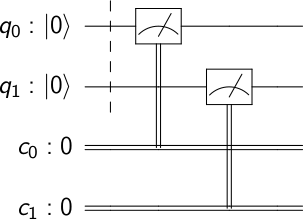

In [7]:
# can browse through various circuits associated to operators
index = 9
print(f'Circuit for O{index:1d}')
circ[circ_idx[index]].draw(output='latex', scale=0.5)

In [10]:
backend_sim = Aer.get_backend('qasm_simulator')
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)

In [9]:
nshots = 8*1021
# stores results indexed by operator 
job = {}
res = {}
for icirc in range(ncircuits):
    job[icirc] = execute(circ[icirc], backend_sim, shots=nshots, memory=True)
    res[icirc] = job[icirc].result()

In [ ]:
# takes in results from a single circuit 
# with memory=True, and estimates
# the uncertanities on the probability of each outcome 
# (currently with bootstrap)
# returns outcome:(pba, std) dictionary
def compute_stats(results):
    # check that there is a single circuit in the results
    # (ambiguous otherwise)
    # TODO
    # pull number of qubits from results
    # generates all possible outcomes given \
    # the number of qubits
    def _generate_bitstrings(nqubits=2):
        if (nqubits == 2):
            return ['00', '10', '01', '11']
        else:
            print("I am hardcoded at the moment")
            raise
    # bootstrap specific?
    # given ensembles of outcomes and a particular outcome
    # calculates the statistics of that outcome:
    # returns outcome:(pba, std) estimates for the outcome
    def _calc_outcome_stats(ensembles, nshots, outcome):
        cts = np.count_nonzero(ensembles==outcome, axis=0)
        pba = np.mean(cts)/nshots
        std = np.std(cts/nshots, ddof = 1) # use unbiased estimator
        return (pba, std)
    outcomes = _generate_bitstrings()
    mem = res.get_memory()
    # stores pba[i][outcome] = [mean, std]
    pba[i] = {outcome:[0.,0.] for outcome in outcomes} 
    # build ensembles
    # TODO retrieve nshots from results
    nshots = 1024
    nens = nshots # choose number of ensemles = number of samples
    nsam = nshots
    ensembles = np.random.choice(mem[i], (nens, nsam))
    stats = {map(lambda outcome:  outcome:_calc_outcome_stats(ensembles, nshots, outcome), outcomes)}
    return stats

In [5]:
import numpy as np

In [189]:
# Function to generate all binary strings  
def _generate_bitstrings(nqubits, all_strings, a_string, irecur):  
  
    if irecur == nqubits: 
        all_strings.append(''.join([bit for bit in a_string]))
        return 
      
    _generate_bitstrings(nqubits, all_strings, a_string + ['0'], irecur + 1)

    _generate_bitstrings(nqubits, all_strings, a_string + ['1'], irecur + 1)

In [190]:
all_strings = []

In [193]:
_generate_bitstrings(2, all_strings, [], 0)

In [194]:
print(all_strings)

['0', '1', '00', '01', '10', '11']


In [10]:
# computes probabilities and statistical uncertainties; 
# also saves raw counts to bootstrap on H directly
mem = {} # stores all measurement results
cts = {} # stores a total count of results 
pba = {} # stores final probabilities 
outcomes = ['00', '10', '01', '11'] # specific two 2-qubit register
for i in range(ncircuits):
    cts[i] = res[i].get_counts(circ[i]) # this just sets the right shape for cts array
    mem[i] = res[i].get_memory(circ[i])
    pba[i] = {outcome:[0.,0.] for outcome in outcomes} # stores pba[i][outcome] = [mean, std]
    nens = nshots
    nsam = nshots
    ensembles = np.random.choice(mem[i], (nens, nsam))
    print(f'{i:d}')
    for outcome in outcomes:
        cts[i][outcome] = np.count_nonzero(ensembles==outcome, axis=0)
        pba[i][outcome][0] = (np.mean(cts[i][outcome])/nshots)
        pba[i][outcome][1] = (np.std(cts[i][outcome], ddof = 1)/nshots)
        print(f'{outcome}: {pba[i][outcome][0]:1.3g}, {pba[i][outcome][1]:1.1g}')

0
00: 1, 0
10: 0, 0
01: 0, 0
11: 0, 0
1
00: 0.247, 0.005
10: 0.249, 0.005
01: 0.252, 0.005
11: 0.252, 0.005
2
00: 0.259, 0.005
10: 0.255, 0.005
01: 0.242, 0.005
11: 0.244, 0.005
3
00: 0.507, 0.005
10: 0.493, 0.005
01: 0, 0
11: 0, 0


In [11]:
# get array of operator indices corresponding to a circuit index
op_idx = {}
for op_index, circ_index in circ_idx.items():
    op_idx[circ_index] = op_idx.setdefault(circ_index, [])
    op_idx[circ_index].append(op_index)

In [12]:
# compute the value of identity measurement
id_meas = [0.0, 0.0] # value, error
# circuit index for diagonal operators is 0 
id_mem = res[0].get_memory(circ[0]) # also compute measurement results to bootstrap on H directly 
id_cts = res[0].get_counts(circ[0]) # this just sets the right shape for cts array
for outcome in outcomes:
    nens = len(id_mem)
    nsam = len(id_mem)
    ensembles = np.random.choice(id_mem, (nens, nsam))
    id_cts[outcome] = np.count_nonzero(ensembles==outcome, axis=0)
    id_meas[0] += pba[0][outcome][0]
    id_meas[1] += pba[0][outcome][1]**2.
id_meas[1] = np.sqrt(id_meas[1])
print(id_meas) # expect value = 1.0 from probability normalization

[1.0, 0.0]


In [13]:
# computing expectation values of operators, which have one set of indices
# from measurement outcomes, which are indexed by circuits. Some operators correspond to the same circuit
# circ_idx[operator_index] is a dictionary of circuit indices keyed on operator indices
# also propagating raw measurement results to bootstrap on H directly
od_meas = {index:[0.0, 0.0] for index in od.keys()} # store (measurement, uncert) for operators here
#od_cts = {}
for circ_index in range(ncircuits): # loop over various circuits 
    print(f'circuit index {circ_index:d}')
    for outcome in outcomes:
        # probabilities of measurements are associated with circuits 
        print(f'{outcome}: {pba[circ_index][outcome][0]:3.3f}, {pba[circ_index][outcome][1]:3.3f}')
    print(op_idx[circ_index])
    for op_index in op_idx[circ_index]:# consider every operator corresponding to current circuit
        # copies counts from circuit measurements to corresponding operator
        #od_cts[op_index] = cts[circ_index][:] # does not modify the counts array
        #print(od_cts[op_index])
        print(f'operator {op_index:d}')
        for outcome in outcomes:       # loop over possible outcomes (measured qubit configurations)
            # eigenvalues multiplying the probabilities are associated with operators
            eigenval = od[op_index][outcome]
            print(f'{outcome}: {eigenval:1.1f}')
            # propagate counts, weighted by the eigenvalues
            #od_cts[op_index][outcome] = np.array(od_cts[op_index][outcome], dtype=np.float64)
            #print(od_cts[op_index][outcome])
            #od_cts[op_index][outcome] *= eigenval
            #print(od_cts[op_index][outcome])
            # multiply probabilities of outcomes by corresponding eigenvalue, sum over eigenvalues
            od_meas[op_index][0] += eigenval * pba[circ_index][outcome][0]  # probability * eigenvalue
            od_meas[op_index][1] += abs(eigenval) * pba[circ_index][outcome][1]  # propagated uncertainty ? FIXME
        # take squre root of sum of squares of uncertainties (assuming uncorrelated projected measurements)
        # od_meas[op_index][1] = np.sqrt(od_meas[op_index][1])
        print(f'{od_meas[op_index][0]:4.4f}, {od_meas[op_index][1]:4.4f}')

circuit index 0
00: 1.000, 0.000
10: 0.000, 0.000
01: 0.000, 0.000
11: 0.000, 0.000
[9, 12, 15]
operator 9
00: 1.0
10: -1.0
01: -1.0
11: 1.0
1.0000, 0.0000
operator 12
00: 1.0
10: -1.0
01: 1.0
11: -1.0
1.0000, 0.0000
operator 15
00: 1.0
10: 1.0
01: -1.0
11: -1.0
1.0000, 0.0000
circuit index 1
00: 0.247, 0.005
10: 0.249, 0.005
01: 0.252, 0.005
11: 0.252, 0.005
[1]
operator 1
00: 1.0
10: -1.0
01: -1.0
11: 1.0
-0.0016, 0.0191
circuit index 2
00: 0.259, 0.005
10: 0.255, 0.005
01: 0.242, 0.005
11: 0.244, 0.005
[5]
operator 5
00: 1.0
10: -1.0
01: -1.0
11: 1.0
0.0056, 0.0191
circuit index 3
00: 0.507, 0.005
10: 0.493, 0.005
01: 0.000, 0.000
11: 0.000, 0.000
[7, 10]
operator 7
00: 1.0
10: -1.0
01: -1.0
11: 1.0
0.0139, 0.0110
operator 10
00: 1.0
10: -1.0
01: 1.0
11: -1.0
0.0139, 0.0110


In [14]:
# combine probabilities and uncertainties to get the the expectation value of H in the fidicial state
H_expect = [0.,0.]
test = {outcome:0.0 for outcome in outcomes} # counts
for i_nz_c in nonzero_proj:
    coeff = coeffs[i_nz_c-1] # shift back to 0-indexed
    value = od_meas[i_nz_c][0]
    error = od_meas[i_nz_c][1]
    H_expect[0] += coeff*value
    H_expect[1] += abs(coeff)*error
    for outcome in outcomes:
        eigenval = od[op_index][outcome]
        test[outcome] += (coeff * eigenval * cts[circ_idx[i_nz_c]][outcome] / nshots)
test2=np.zeros(nsam)
for outcome in outcomes:
    test2 += test[outcome]
    test2 += coeffs[15]*(id_cts[outcome]/nshots)
# add the trace back
mean2= np.mean(test2)
std2 = np.std(test2)
print((mean2, std2))
# add the trace back
H_expect[0] += coeffs[15] * id_meas[0] 
H_expect[1] += abs(coeffs[15]) * id_meas[1]
print(H_expect)

(-0.1833322988101964, 0.01479402233762066)
[-0.18193626909202765, 0.02936605383529714]


In [15]:
mathematica_res = -0.20035992801439712
#print(H_expect)
print((mean2, std2))
#print(H_expect[0]+H_expect[1], H_expect[0]-H_expect[1])
print((mean2+std2, mean2-std2))
print(mathematica_res)

(-0.1833322988101964, 0.01479402233762066)
(-0.16853827647257572, -0.19812632114781706)
-0.20035992801439712


## Plot results

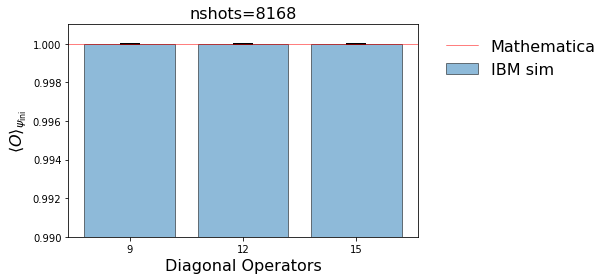

In [16]:
import matplotlib.pyplot as plt
diag_bars =  np.arange(len(diag))
avgs = [od_meas[diag_index][0] for diag_index in diag]
stds = [od_meas[diag_index][1] for diag_index in diag]
fig, ax = plt.subplots()
ax.bar(diag_bars, avgs, yerr=stds, align='center', alpha=0.5, ecolor='black',
       edgecolor='k',
       error_kw=dict(lw=0.5, capsize=10, capthick=2.0),
       label='IBM sim')
ax.set_ylabel(r'$\langle O \rangle_{\psi_{\mathrm{ini}}}$', fontsize=16)
ax.set_xlabel('Diagonal Operators', fontsize=16)
ax.set_xticks(diag_bars)
ax.set_xticklabels(diag)
ax.set_title(f'nshots={nshots:d}', fontsize=16)
ax.axhline(y = 1.0, color='r', linewidth = 0.5, label='Mathematica')
plt.ylim([0.99, 1.001])
plt.tight_layout()
plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("op_diag.png", dpi=300)

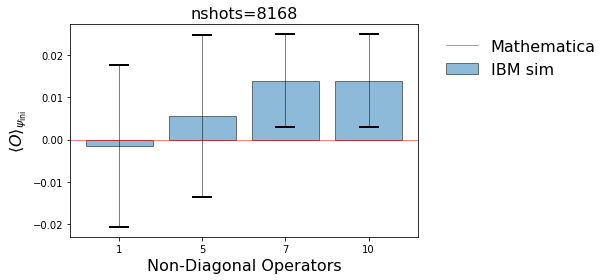

In [17]:
nondiag_bars =  np.arange(len(nondiag))
avgs = [od_meas[diag_index][0] for diag_index in nondiag]
stds = [od_meas[diag_index][1] for diag_index in nondiag]
fig, ax = plt.subplots()
ax.bar(nondiag_bars, avgs, yerr=stds, align='center', alpha=0.5, ecolor='black',
       edgecolor='k',
       error_kw=dict(lw=0.5, capsize=10, capthick=2.0),
       label='IBM sim')
ax.set_ylabel(r'$\langle O \rangle_{\psi_{\mathrm{ini}}}$', fontsize=16)
ax.set_xlabel('Non-Diagonal Operators', fontsize=16)
ax.set_xticks(nondiag_bars)
ax.set_xticklabels(nondiag)
ax.set_title(f'nshots={nshots:d}', fontsize=16)
ax.axhline(y = 0.0, color='r', linewidth = 0.5, label='Mathematica')
plt.tight_layout()
plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("op_nondiag.png", dpi=300)